In [1]:
import bmll2 as b2
b2.get_file('modules/auxiliary_functions.py')

'auxiliary_functions.py'

In [2]:
# can do this when i have converted the notebooks to .py files
# import auxiliary_functions
import auxiliary_functions as af

import random
import math
import pandas as pd
import numpy as np
from pandas import StringDtype

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogFormatterSciNotation
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import t

In [3]:
b2.get_file('top_100(Volume)/GFI.csv')
GFI = pd.read_csv('GFI.csv', parse_dates = ['DateTime', 'Date'])
GFI = GFI.rename(columns = {'Ticker' : 'RIC'})
GFI = GFI.sort_values(['DateTime', 'ExchangeSequenceNo'])

b2.get_file('top_100(Volume)/GRT.csv')
GRT = pd.read_csv('GRT.csv', parse_dates = ['DateTime', 'Date'])
GRT = GRT.rename(columns = {'Ticker' : 'RIC'})
GRT = GRT.sort_values(['DateTime', 'ExchangeSequenceNo'])

In [49]:
GRT.head()

,MIC,RIC,ListingId,Date,DateTime,ExchangeSequenceNo,Daily Volume,Daily Volatility,Trade Sign,Price,Volume,Mid-price before,Mid-price after(immediate),Mid-price after(delayed),Daily Volatility(alt)
141968,XJSE,GRT,418405583,2023-01-03,2023-01-03 09:03:21.591816,111651,6862853.0,0.035155,1,1459.0,5.0,1454.5,1454.5,1455.5,0.034551
141969,XJSE,GRT,418405583,2023-01-03,2023-01-03 09:03:44.654214,117600,6862853.0,0.035155,-1,1453.0,6079.0,1455.5,1455.5,1455.5,0.034551
141970,XJSE,GRT,418405583,2023-01-03,2023-01-03 09:03:44.654527,117607,6862853.0,0.035155,-1,1452.0,3307.0,1455.5,1455.5,1453.0,0.034551
141971,XJSE,GRT,418405583,2023-01-03,2023-01-03 09:03:55.963851,120811,6862853.0,0.035155,-1,1450.0,2961.0,1453.0,1449.5,1447.0,0.034551
141972,XJSE,GRT,418405583,2023-01-03,2023-01-03 09:04:20.935449,160872,6862853.0,0.035155,-1,1445.0,11354.0,1447.0,1445.5,1445.0,0.034551


In [4]:
b2.get_file('test_data/homo_4_immediate(100).csv')
impact_data = pd.read_csv('homo_4_immediate(100).csv', parse_dates = ['Date', 'Start time', 'End time'])

GRT_impact = impact_data[impact_data['RIC'] == 'GRT'][['RIC', 'Date', '20 AD volatility', '20 AD volume']]
GFI_impact = impact_data[impact_data['RIC'] == 'GFI'][['RIC', 'Date', '20 AD volatility', '20 AD volume']]

In [9]:
%%time
# power distribution and N = 4 gave a very crude but maybe passable result

#impact_profile_GFI = pd.DataFrame(columns = ['phi', 'dynamic impact', 'dynamic impact 20 AD', '20 AD volume', '20 AD volatility'])

phi_grid = np.linspace(0, 1, 101)
all_interp_profiles_GFI = []

impact_profile_list_GFI = []

for date, day_D in GFI.groupby('Date', sort = True):
        print(date)

        trades = day_D.loc[day_D['Price'] != 0]
        N = 20
        f = af.trader_participation(N = N, method = 'power', alpha = 2, f_min = 1, f_max = trades.shape[0], seed = 1)
        c = af.cumulative_probs(f)

        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) == 0:
                continue

            else:
                for i in range(len(trader_n_metaorders)):

                    metaorder_i = trader_n_metaorders[i]
                    
                    if metaorder_i.empty:
                        continue

                    if len(metaorder_i) < 10:
                        continue

                    date           = metaorder_i['Date'].iloc[0]
                    vol_20_AD      = GFI_impact[GFI_impact['Date'] == date]['20 AD volatility'].iloc[0]
                    volume_20_AD   = GFI_impact[GFI_impact['Date'] == date]['20 AD volume'].iloc[0]
                    Q              = metaorder_i['Volume'].sum()
                    volatility     = metaorder_i['Daily Volatility']

                    #if (((Q / volume_20_AD) <= 10 ** -4) or ((Q / volume_20_AD) >= 10 ** -2)):
                    #    continue
                        
                    phi    = metaorder_i['Volume'].cumsum() / Q
                    sign   = metaorder_i['Trade Sign'].iloc[0]
                    impact = sign * np.log(metaorder_i['Mid-price after(immediate)'] / metaorder_i['Mid-price before'].iloc[0]) #/ denom #np.sqrt(phi) *
                    scaled_impact_vol  = impact / (vol_20_AD * np.sqrt(Q / volume_20_AD))
                    scaled_impact      = impact / (vol_20_AD * np.sqrt(Q))
                    impact_profile = pd.DataFrame({'phi': phi, 'impact': impact, 'scaled impact': scaled_impact, 'scaled impact(with volume)': scaled_impact_vol,
                                                   '20 AD volume': volume_20_AD, '20 AD volatility': vol_20_AD, 'Q': Q}).reset_index(drop = 'True')
                    phi_i = phi.values
                    g_i   = scaled_impact.values
                    interp_profile = np.interp(phi_grid, phi_i, g_i)

                    if not impact_profile.empty and not impact_profile.isna().all().all():
                        all_interp_profiles_GFI.append(interp_profile)
                        impact_profile_list_GFI.append(impact_profile)
                        #impact_profile_GFI = pd.concat([impact_profile_GFI, impact_profile], ignore_index = True)


impact_profile_GFI  = pd.concat(impact_profile_list_GFI, ignore_index = True)
impact_profile_GFI.to_csv('GFI_impact_profile.csv', index = False)
b2.put_file('GFI_impact_profile.csv', 'test_data')

# takes about 9 minutes to run


2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-13 00:00:00


In [10]:
%%time
# power distribution and N = 4 gave a very crude but maybe passable result

#impact_profile_GRT = pd.DataFrame(columns = ['phi', 'dynamic impact', 'dynamic impact 20 AD', '20 AD volume', '20 AD volatility'])

phi_grid = np.linspace(0, 1, 101)
all_interp_profiles_GRT = []

impact_profile_list_GRT = []

for date, day_D in GRT.groupby('Date', sort = True):
        print(date)

        trades = day_D.loc[day_D['Price'] != 0]
        N = 20
        f = af.trader_participation(N = N, method = 'power', alpha = 2, f_min = 1, f_max = trades.shape[0], seed = 1)
        c = af.cumulative_probs(f)

        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) == 0:
                continue

            else:
                for i in range(len(trader_n_metaorders)):

                    metaorder_i = trader_n_metaorders[i]
                    
                    if metaorder_i.empty:
                        continue

                    if len(metaorder_i) < 10:
                        continue

                    date           = metaorder_i['Date'].iloc[0]
                    vol_20_AD      = GRT_impact[GRT_impact['Date'] == date]['20 AD volatility'].iloc[0]
                    volume_20_AD   = GRT_impact[GRT_impact['Date'] == date]['20 AD volume'].iloc[0]
                    Q              = metaorder_i['Volume'].sum()
                    volatility     = metaorder_i['Daily Volatility']

                    #if (((Q / volume_20_AD) <= 10 ** -4) or ((Q / volume_20_AD) >= 10 ** -2)):
                    #    continue
                        
                    phi    = metaorder_i['Volume'].cumsum() / Q
                    sign   = metaorder_i['Trade Sign'].iloc[0]
                    impact = sign * np.log(metaorder_i['Mid-price after(immediate)'] / metaorder_i['Mid-price before'].iloc[0]) #/ denom #np.sqrt(phi) *
                    scaled_impact_vol  = impact / (vol_20_AD * np.sqrt(Q / volume_20_AD))
                    scaled_impact      = impact / (vol_20_AD * np.sqrt(Q))
                    impact_profile = pd.DataFrame({'phi': phi, 'impact': impact, 'scaled impact': scaled_impact, 'scaled impact(with volume)': scaled_impact_vol,
                                                   '20 AD volume': volume_20_AD, '20 AD volatility': vol_20_AD, 'Q': Q}).reset_index(drop = 'True')
                    phi_i = phi.values
                    g_i   = scaled_impact.values
                    interp_profile = np.interp(phi_grid, phi_i, g_i)

                    if not impact_profile.empty and not impact_profile.isna().all().all():
                        all_interp_profiles_GRT.append(interp_profile)
                        impact_profile_list_GRT.append(impact_profile)
                        #impact_profile_GRT = pd.concat([impact_profile_GRT, impact_profile], ignore_index = True)


impact_profile_GRT  = pd.concat(impact_profile_list_GRT, ignore_index = True)
impact_profile_GRT.to_csv('GRT_impact_profile.csv', index = False)
b2.put_file('GRT_impact_profile.csv', 'test_data')

# takes about 1 minutes to run


2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-13 00:00:00


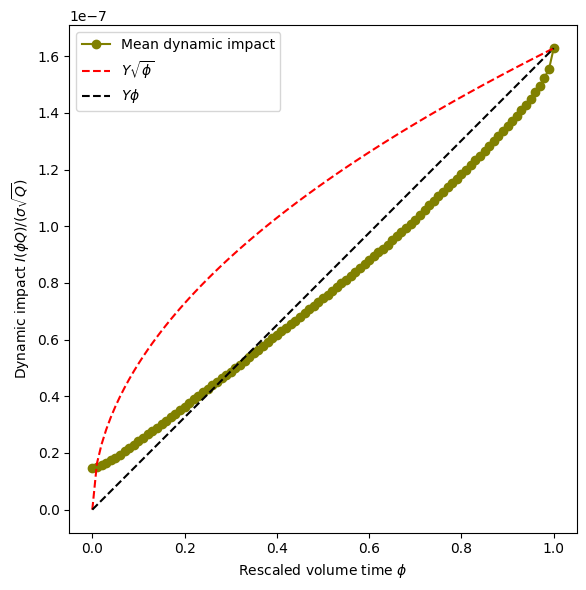

In [204]:
all_interp_profiles_GRT = np.array(all_interp_profiles_GRT)

mean_profile_GRT = np.mean(all_interp_profiles_GRT, axis = 0)
#std_profile_GRT  = np.std(all_interp_profiles_GRT, axis = 0)

Y = mean_profile_GRT[-1]   # match the endpoint at phi = 1

concave_line = Y * np.sqrt(phi_grid)
linear_line  = Y * phi_grid

fig, ax = plt.subplots(figsize = (6,6))

ax.plot(phi_grid, mean_profile_GRT, marker = 'o', label = 'Mean dynamic impact', color = 'olive')
ax.plot(phi_grid, concave_line, '--', label = r'$Y \sqrt{\phi}$', color = 'red')
ax.plot(phi_grid, linear_line, '--', label = r'$Y \phi$', color = 'black')

ax.set_xlabel(r'Rescaled volume time $\phi$')
ax.set_ylabel(r'Dynamic impact $I(\phi Q)/(\sigma \sqrt{Q})$')

ax.legend()
ax.set_box_aspect(1)
plt.tight_layout()
plt.show()

In [3]:
b2.get_file('test_data/GFI_impact_profile.csv')
b2.get_file('test_data/GRT_impact_profile.csv')

impact_profile_GFI = pd.read_csv('GFI_impact_profile.csv')
impact_profile_GRT = pd.read_csv('GRT_impact_profile.csv')

In [12]:
impact_profile_GRT.tail()
test_data = impact_profile_GRT[impact_profile_GRT['phi'] == 1]
test_data.head()

,phi,impact,scaled impact,scaled impact(with volume),20 AD volume,20 AD volatility,Q
12,1.0,0.000344,0.000080,0.209805,6862853.0,0.035155,14954.0
23,1.0,0.002065,0.000413,1.081983,6862853.0,0.035155,20235.0
33,1.0,-0.000689,-0.000096,-0.250973,6862853.0,0.035155,41845.0
45,1.0,0.009954,0.001459,3.821334,6862853.0,0.035155,37677.0
59,1.0,0.003100,0.000633,1.659460,6862853.0,0.035155,19375.0


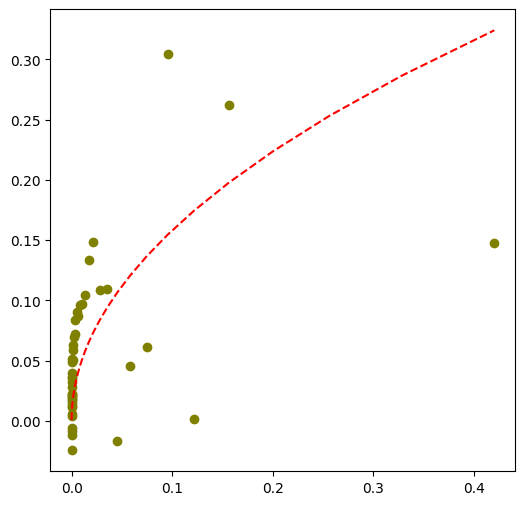

In [7]:

vols = (test_data['Q'] / test_data['20 AD volume'])
bins = np.logspace(np.log10(vols.min()), np.log10(vols.max()), 50, base = 10, endpoint = True)
#bins = np.linspace(vols.min(), vols.max(), 40)
volume_bins_GRT = pd.cut(vols, bins = bins)

impact_bins_vals_GRT    = (test_data['impact'] / (test_data['20 AD volatility'])).groupby(volume_bins_GRT, observed = False).mean()
volume_bins_centers_GRT = [interval.mid for interval in impact_bins_vals_GRT.index.categories]

alpha          = 0.5
sqrt_law       = alpha * np.sqrt(volume_bins_centers_GRT)

fig, ax = plt.subplots(figsize = (6, 6))

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.scatter(volume_bins_centers_GRT, impact_bins_vals_GRT, color = 'olive', marker = 'o', label = 'GRT dynamic impact')
ax.plot(volume_bins_centers_GRT, sqrt_law, linestyle = '--', color = 'red', label = r'0.5 $\times \sqrt{Q/V_{D}}$')
plt.show()